In [2]:
import argparse
import os
import numpy as np
import math

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch
import shutil
import time

os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)
shutil.rmtree('images_ensemble_mnist10_classifier_small')
os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)


In [6]:
class arg_parser_subst():
    def __init__(self):
        self.n_epochs = 500 
        self.batch_size = 100
        self.batch_size_g = 100
        self.lr = 0.0002 
        self.b1 = 0.5 
        self.b2 = 0.999 
        self.n_cpu = 12 
        self.latent_dim = 100 
        self.img_size = 28
        self.channels = 1
        self.sample_interval = 400 
        self.n_paths_G = 50 # number of generators
        self.classifier_para = 0.001
        self.classifier_para_g = 0.001
        

In [7]:
opt = arg_parser_subst()

In [8]:
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        modules = nn.ModuleList()
        
        for _ in range(opt.n_paths_G):
            modules.append(
                nn.Sequential(
                *block(opt.latent_dim, 128),
                *block(128, 512),
                nn.Linear(512, int(np.prod(img_shape))),
                nn.Tanh()
            ))
        self.paths = modules

    def forward(self, z):
        img = []
        for path in self.paths:
            img.append(path(z).view(img.size(0), *img_shape))
        img = torch.cat(img, dim=0)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(int(np.prod(img_shape)), 512)
        self.lr1 = nn.LeakyReLU(0.2, inplace=True)
        self.fc2 = nn.Linear(512, 256)
        self.lr2 = nn.LeakyReLU(0.2, inplace=True)
        
        modules = nn.ModuleList()
        
        modules.append(nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid(),
                ))
        modules.append(nn.Sequential(
            nn.Linear(256, opt.n_paths_G),
                ))
        self.paths = modules
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        img_flat = self.lr2(self.fc2(self.lr1(self.fc1(img_flat))))
        
        validity = self.paths[0](img_flat)
        classifier = F.log_softmax(self.paths[1](img_flat), dim=1)
        
        return validity, classifier

adversarial_loss = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


In [9]:
# Configure data loader
os.makedirs('data/fmnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data/fmnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([.5],[.5])
                   ])),
    batch_size=opt.batch_size, shuffle=True)




In [10]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [11]:

%matplotlib inline
def show(img):
    npimg = img.detach().numpy()
    plt.figure(figsize = (opt.n_paths_G//2,opt.n_paths_G//2))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



[Epoch 0/500] [Batch 599/600] [D loss: 29.478695] [G loss: 47.091178] [C loss 1: 0.000000] [C loss 2: 0.116100] [Acc: 84.44%] 	 Time Interv: 111.270643


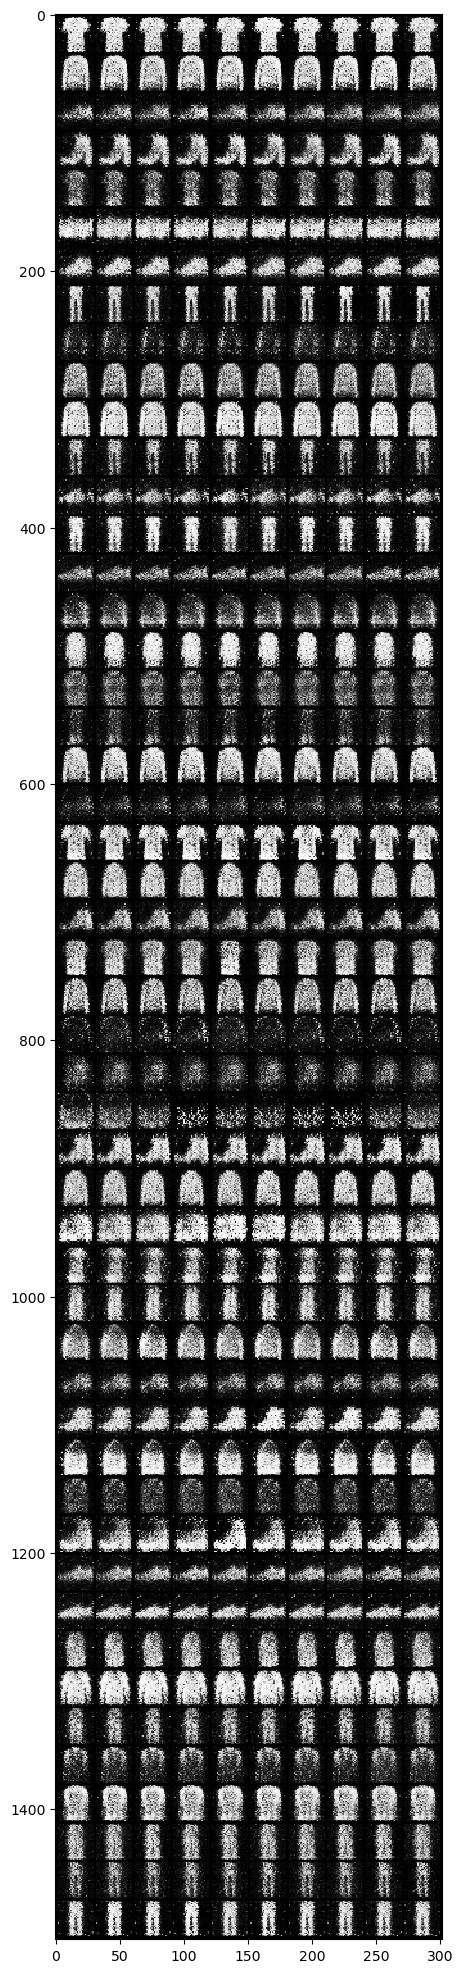

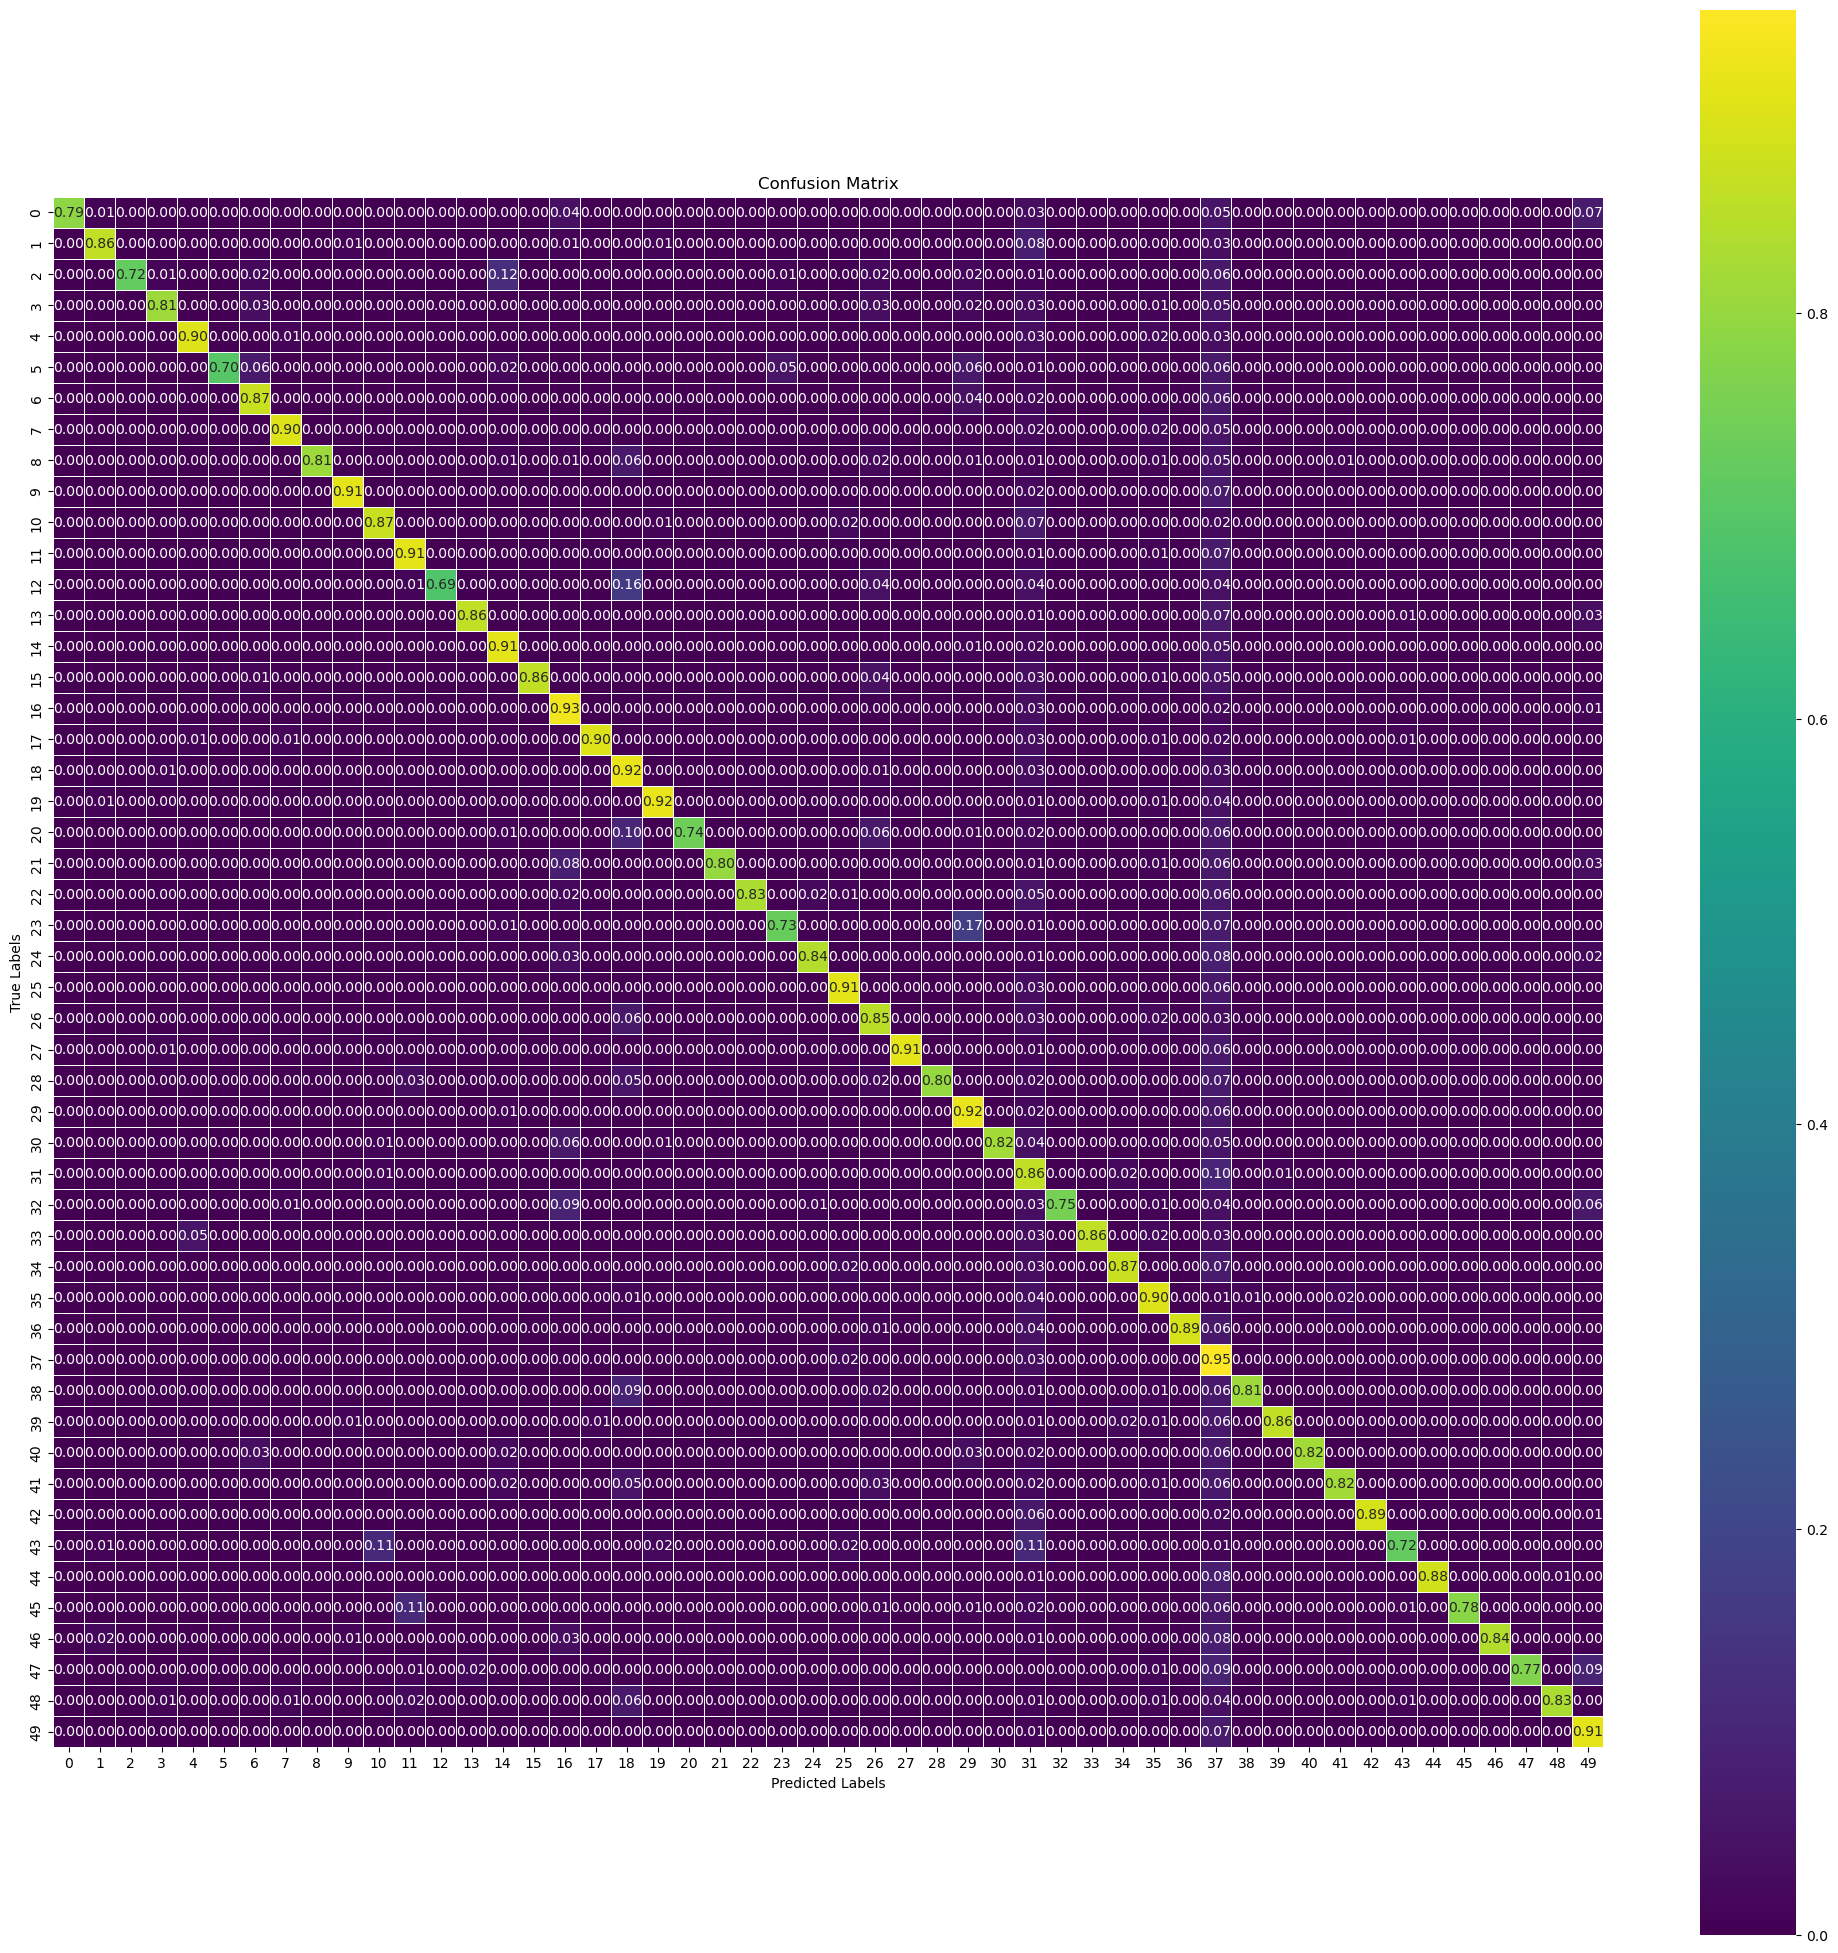

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For visualizing the confusion matrix

for epoch in range(opt.n_epochs):

    start = time.time()
    all_targets = []
    all_predictions = []
    
    epoch_start = 0
    
    g_loss_epoch = 0
    d_loss_epoch = 0
    c_loss_1_epoch = 0
    c_loss_2_epoch = 0
    
    correct_predictions = 0
    total_predictions = 0

    num_batches = len(dataloader)
    
    for i, (imgs, _) in enumerate(dataloader):
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        # -----------------------------------------------------
        #  Train Generator 
        # -----------------------------------------------------

        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size_g, opt.latent_dim))))
        g_loss = 0 
        c_loss_1 = 0 
        
        for k in range(opt.n_paths_G):

            gen_imgs = generator.paths[k](z)
            validity, classifier = discriminator(gen_imgs)
            g_loss += adversarial_loss(validity, valid)

            target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)
            
            c_loss_1 += F.nll_loss(classifier, target) * opt.classifier_para_g

            _, predicted = torch.max(classifier.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
            # Collect all targets and predictions for confusion matrix
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
        g_loss_epoch += g_loss
        c_loss_1_epoch += c_loss_1       
        g_loss = g_loss + c_loss_1
        
        g_loss.backward()
        optimizer_G.step()
        
        # ------------------------------------------------------------------------
        #  Train Discriminator and Classifier (WE CALL THIS STAGE PHASE 2)
        # ------------------------------------------------------------------------

        optimizer_D.zero_grad()

        d_loss = 0 #adversarial loss for discrimination to be applied to the discriminator
        c_loss_2 = 0 #classification loss to be applied to the classifier
        
        #loss of the discriminator with real images
        validity, classifier = discriminator(real_imgs)
        real_loss = adversarial_loss(validity, valid)
        
        temp = [] #variable to store images for plot
        
        #again we iterate over each of the generators
        for k in range(opt.n_paths_G):

            # generates a batch of images with generator k
            gen_imgs = generator.paths[k](z).view(imgs.shape[0], *img_shape)
            temp.append(gen_imgs[0:10, :])

            #again we measure the outputs of the discriminator and the classifier 
            validity, classifier = discriminator(gen_imgs.detach())
            
            #loss of the discriminator with fake images
            fake_loss = adversarial_loss(validity, fake)
            
            #sums up the fake and true losses
            d_loss += (real_loss + fake_loss) / 2

            #again we calculate the loss of the classifier. Note that it is calculated...
            #...in exactly the same way as before, but only after the...
            #...generator has already had its weights updated in PHASE 1.
            #reminder: opt.classifier_para is just a multiplicative constant of the loss
            target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)
            c_loss_2 += F.nll_loss(classifier, target) * opt.classifier_para
        
        #images for plot
        plot_imgs = torch.cat(temp, dim=0)

        #again, we accumulate the losses to visualize the total for the epoch
        d_loss_epoch += d_loss
        c_loss_2_epoch += c_loss_2
        
        #we add both losses into the same variable 
        d_loss = d_loss + c_loss_2
        #jointly apply the gradients to the layers of the discriminator and classifier
        d_loss.backward()
        optimizer_D.step()
    
    #printing training information
    interval = time.time() - start
    
    if (epoch < 20 and epoch % 5 == 0) or (epoch > 20 and epoch % 20 == 0):
        
        # print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] \t Time Interv: %f"
        #        % (epoch, opt.n_epochs, i, num_batches, d_loss_epoch.item()/num_batches, g_loss_epoch.item()/num_batches, 
        #           c_loss_1_epoch.item()/num_batches, c_loss_2_epoch.item()/num_batches, interval))

        classification_accuracy = 100.0 * correct_predictions / total_predictions

        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] [Acc: %.2f%%] \t Time Interv: %f"
            % (epoch, opt.n_epochs, i, num_batches, d_loss_epoch.item()/num_batches, g_loss_epoch.item()/num_batches, 
                c_loss_1_epoch.item()/num_batches, c_loss_2_epoch.item()/num_batches, classification_accuracy, interval))

        show(make_grid(plot_imgs[:opt.n_paths_G*10].cpu(), nrow=10, normalize=True))
        plt.show()
        
        # Compute and print confusion matrix at the end of each epoch
        cm = confusion_matrix(all_targets, all_predictions)/(opt.batch_size_g*len(dataloader))
        cm_rounded = np.around(cm, decimals=2)
        fig, ax = plt.subplots(figsize=(opt.n_paths_G//2, opt.n_paths_G//2))
        # sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
        sns.heatmap(cm_rounded, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'viridis')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Confusion Matrix')
        plt.show()
